# Hyperwave: knowledge base embedding

Let's import all the libraries needed for our knowledge base embedding.

In [64]:
import os
import numpy as np
import xarray as xr
import warnings
import torchhd
import torch

from urllib3.exceptions import NotOpenSSLWarning


Now, let's configure the runtime environment settings.

In [65]:
# I/O configuration
input_folder = '../data/ncdf'
output_folder = '../data/ncdf'

# Runtime configuration
os.makedirs(output_folder, exist_ok=True)
# np.set_printoptions(suppress=True, precision=8)
# torch.set_printoptions(precision=8, sci_mode=False)

# Ignore annoying urllib3 warnings
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

# Load dataset
dataset = xr.load_dataarray(os.path.join(input_folder, "nrm.orx.dataset.nc"))

Other than simulated signals, which are by themselves hypervectors of 20'880 dimensions, we need two kind of additional hypervectors: a random set to label central frequencies, and another one to label radii sizes.

In [ ]:
no_radii = dataset.radius.size
no_frequencies = dataset.frequency.size
embedding_size = 32768
random_embedding_size = 1000
vsa_encoding = "BSC"

def embed(data, in_features, out_features, embed_type="random", vsa="BSC"):
    mapping = {
        "random": torchhd.embeddings.Random,
        "level": torchhd.embeddings.Level,
        "density": torchhd.embeddings.Density
    }
    if embed_type not in mapping:
        raise ValueError(f"Unknown embedding type: {embed_type}")
    embedding = mapping[embed_type](in_features, out_features, vsa=vsa)
    return embedding(data)

frequencies_random_features = torch.randn(no_frequencies, random_embedding_size)
frequency_embeddings = embed(
    frequencies_random_features,
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

radii_random_features = torch.randn(no_radii, random_embedding_size)
radius_embeddings = embed(
    radii_random_features,
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

print(f"Frequencies embeddings: {np.shape(frequency_embeddings)}")
print(f"Radii embeddings: {np.shape(radius_embeddings)}")
print(frequency_embeddings)


Frequencies embeddings: torch.Size([10, 3480])
Radii embeddings: torch.Size([45, 3480])
BSCTensor([[ True,  True, False,  ..., False,  True,  True],
           [ True, False,  True,  ...,  True,  True, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [ True,  True, False,  ..., False,  True, False],
           [False,  True,  True,  ...,  True,  True, False],
           [ True, False, False,  ...,  True,  True, False]])


Now we should embed our simulated signals into a suitable encoding. Since we have used HRR for both central frequencies and radii labels, we will do the same for our signals.

In [67]:
testset_embeddings = torch.tensor(dataset.sel(radius=300).values)

In [68]:
signal_embeddings = xr.apply_ufunc(
    embed,
    testset_embeddings,
    # torch.tensor(dataset.values),
    dataset.time.size,
    embedding_size,
    "density",
    vsa_encoding,
    vectorize=True,   # Allows element-wise mapping
)
print(f"Signals embeddings: {np.shape(signal_embeddings)}")
print(signal_embeddings)

Signals embeddings: torch.Size([10, 3480])
BSCTensor([[False, False,  True,  ...,  True, False,  True],
           [False,  True,  True,  ...,  True, False,  True],
           [False, False, False,  ...,  True, False,  True],
           ...,
           [False,  True,  True,  ...,  True, False,  True],
           [False, False, False,  ...,  True, False,  True],
           [False,  True,  True,  ...,  True, False,  True]])


Now that we have all the embeddings for our dataset, we can incrementally try some experiments. For example, let's create a knowledge base hypervector binding central frequency labels with the corresponding simulated signal:

BSCTensor([[ True,  True,  True,  ...,  True, False,  True]])


<StemContainer object of 3 artists>

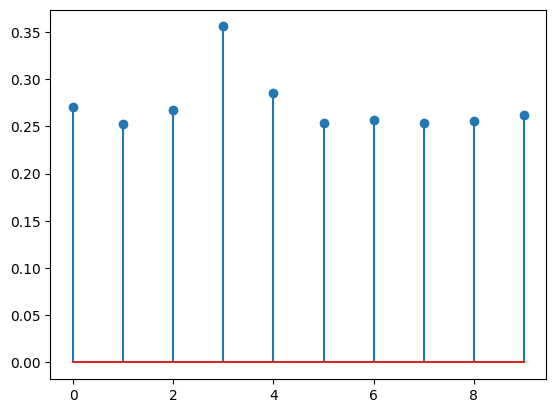

In [69]:
# Create the kbe (knowledge base embedding) for radius=10
# Operations syntax:                   bind := * | bundle := +
# kbe[radius=10] :=
#   [frequency=1MHz] * [signal=(radius=10,frequency=1MHz)    +
#   [frequency=1MHz] * [signal=(radius=10,frequency=2MHz)    +
#   ...
#   [frequency=10MHz] * [signal=(radius=10,frequency=9MHz)]  +
#   [frequency=10MHz] * [signal=(radius=10,frequency=10MHz)]

kbe = torchhd.hash_table(frequency_embeddings, signal_embeddings)

# Let's assume we want to know what is the signal like at 4MHz
query_embedding = torchhd.inverse(frequency_embeddings[3])
result = torchhd.bind(kbe, query_embedding)
# Now let's perform a memory cleanup: the result vector should be the
# closest to our simulated signal at frequency=4MHz
print(torchhd.cleanup(result, signal_embeddings))

torchhd.utils.plot_similarity(result, signal_embeddings)


We can see that the result has most similarity with element in position 3, i.e. with the signal having central frequency equal to 4MHz.

In [70]:
no_simulations = 10
correct_validations = 0
for i in np.arange(no_simulations):
    frequencies_random_features = torch.randn(no_frequencies, random_embedding_size)
    frequency_embeddings = embed(
        frequencies_random_features,
        in_features=random_embedding_size,
        out_features=embedding_size,
        embed_type="density",
        vsa=vsa_encoding)
    kbe = torchhd.hash_table(frequency_embeddings, signal_embeddings)
    # Let's assume we want to know what is the signal like at 4MHz
    query_embedding = torchhd.inverse(frequency_embeddings[3])
    result = torchhd.bind(kbe, query_embedding)
    nearest_match = torchhd.cleanup(result, frequency_embeddings)
    # nearest_match = nearest_inner_prod(result, frequency_embeddings)
    if (nearest_match == frequency_embeddings[3]).all():
        correct_validations += 1
print(f"Query matching accuracy: {correct_validations/no_simulations}")
    

Query matching accuracy: 0.0
